In [1]:
import sys

import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import groupby
from operator import itemgetter

sys.path.insert(0, '../scripts')
from flaHMM_functions import *

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

## Define list of genome assemblies to be included
Selected genomes must have left and right arm of chromosome 2 and 3.

In [2]:
species_list=['Dyak.GCF_000005975','Dyak.GCF_016746365','Dyak.droYak2',
              'Dsan.GCF_016746245',
              'Dtei.GCF_016746235',
              'Dsim.GCF_000754195','Dsim.GCF_016746395','Dsim.droSim1',
              'Dsec.GCF_004382195',
              'Dmau.GCF_004382145',
              'Dmel.dm6',
              'Dsubp.GCF_014743375']

## Create Centromere and Centromere-like coordinates
Using a sliding window of 5 bins.

In [3]:
slidding_window=5
results_coordinates=np.array(['species', 'chr', 'start', 'end','bin_start', 'bin_end'])

for species in tqdm(species_list):
    all_data=read_proces_05files(species,'bins/bins_100k/').reset_index(drop=True)
    all_data['coverage_sum']=all_data['coverage_plus']+all_data['coverage_minus']
    all_data['coverage_mean']=(all_data['coverage_plus']+all_data['coverage_minus'])/2
    
    for chromosome in ['chr2L','chr2R','chr3L','chr3R']:
        all_data_subset=all_data[all_data['chr']==chromosome]
        centromeric_chunks=[]
        #The chunker function selects 5 100k bins at a time
        for chunk in chunker(all_data_subset,slidding_window):
            #Remove chunks that have an average threshold lesss than 0.1
            if chunk['coverage_mean'].mean()<0.1:
                continue
            else:
                #keep only the chunks that pass the threshold
                centromeric_chunks.append(chunk.index.tolist())
        # If centromeric chunk number is zero that means that none bins out of the 5 have a high TE content
        if len(centromeric_chunks)==0:
            start=0
            end=0
            start_coordinates=int(start)
            end_coordinates=int(end)
        else:
            test_list='nothing'
            n='nothing'
            
            ranges=[]
            data = pd.DataFrame(centromeric_chunks).melt().sort_values('value').dropna()['value'].tolist()
            
            for k,g in groupby(enumerate(data),lambda x:x[0]-x[1]):
                group = (map(itemgetter(1),g))
                group = list(map(int,group))
                ranges.append((group[0],group[-1]))
                
            ranges_length={}
            for i in ranges:
                ranges_length[i]=i[1]-i[0]
                
            for start, end in ranges_length:
                if end-start>=0:
            
                    start_coordinates=int(all_data_subset[all_data_subset.index.isin([start])]['bin_start'].tolist()[0]/100000)
                    end_coordinates=int(all_data_subset[all_data_subset.index.isin([end])]['bin_end'].tolist()[0]/100000)
                    bin_start_100k=all_data_subset[all_data_subset.index.isin([start])]['bin_start'].tolist()[0]
                    bin_end_100k=all_data_subset[all_data_subset.index.isin([end])]['bin_end'].tolist()[0]
                
                    results_coordinates=np.vstack([results_coordinates, np.array([species, chromosome, start_coordinates, end_coordinates,bin_start_100k,bin_end_100k])])
                else:
                    print('error')
                    continue
                    
                    
results_coordinates=pd.DataFrame(data=results_coordinates[1:], columns=results_coordinates[0])
print(results_coordinates.shape)

100%|██████████| 12/12 [00:00<00:00, 13.42it/s]

(54, 6)


In [4]:
results_coordinates['start']=results_coordinates['start'].astype(int)
results_coordinates['end']=results_coordinates['end'].astype(int)
results_coordinates['bin_start']=results_coordinates['bin_start'].astype(int)
results_coordinates['bin_end']=results_coordinates['bin_end'].astype(int)
results_coordinates['length']=results_coordinates['bin_end']-results_coordinates['bin_start']
results_coordinates=results_coordinates.reset_index(drop=True)
print(results_coordinates.shape)
results_coordinates.head()


(54, 7)


,species,chr,start,end,bin_start,bin_end,length
0,Dyak.GCF_000005975,chr2L,205,223,20500000,22324452,1824452
1,Dyak.GCF_000005975,chr2R,0,15,0,1500000,1500000
2,Dyak.GCF_000005975,chr3L,235,241,23500000,24197627,697627
3,Dyak.GCF_000005975,chr3R,0,10,0,1000000,1000000
4,Dyak.GCF_016746365,chr2L,205,310,20500000,31000000,10500000


In [5]:
results_coordinates=results_coordinates.sort_values(['species','chr','length' ], ascending=False).drop_duplicates(subset=['species','chr'])
print(results_coordinates.shape)

(47, 7)


In [6]:
all_data_subset

,chr,bin_start,bin_end,transposon_overlap_plus,base_overlap_plus,bin_length,coverage_plus,strand_plus,transposon_overlap_minus,base_overlap_minus,coverage_minus,strand_minus,coverage_sum,coverage_mean
23,chr3R,0,100000,4,1654,100000,0.01654,plus,5,466,0.004660,minus,0.021200,0.010600
24,chr3R,100000,200000,6,2146,100000,0.02146,plus,1,55,0.000550,minus,0.022010,0.011005
25,chr3R,200000,300000,4,1008,100000,0.01008,plus,7,1168,0.011680,minus,0.021760,0.010880
26,chr3R,300000,400000,4,1089,100000,0.01089,plus,6,2095,0.020950,minus,0.031840,0.015920
27,chr3R,400000,500000,8,1663,100000,0.01663,plus,3,314,0.003140,minus,0.019770,0.009885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,chr3R,19800000,19900000,8,6462,100000,0.06462,plus,6,927,0.009270,minus,0.073890,0.036945
222,chr3R,19900000,20000000,3,3216,100000,0.03216,plus,4,1260,0.012600,minus,0.044760,0.022380
223,chr3R,20000000,20100000,4,8375,100000,0.08375,plus,5,1282,0.012820,minus,0.096570,0.048285
224,chr3R,20100000,20200000,22,11945,100000,0.11945,plus,18,2876,0.028760,minus,0.148210,0.074105


## Visualise selected annotations for Dmel.dm6 (Figure S1)

  0%|          | 0/1 [00:00<?, ?it/s]

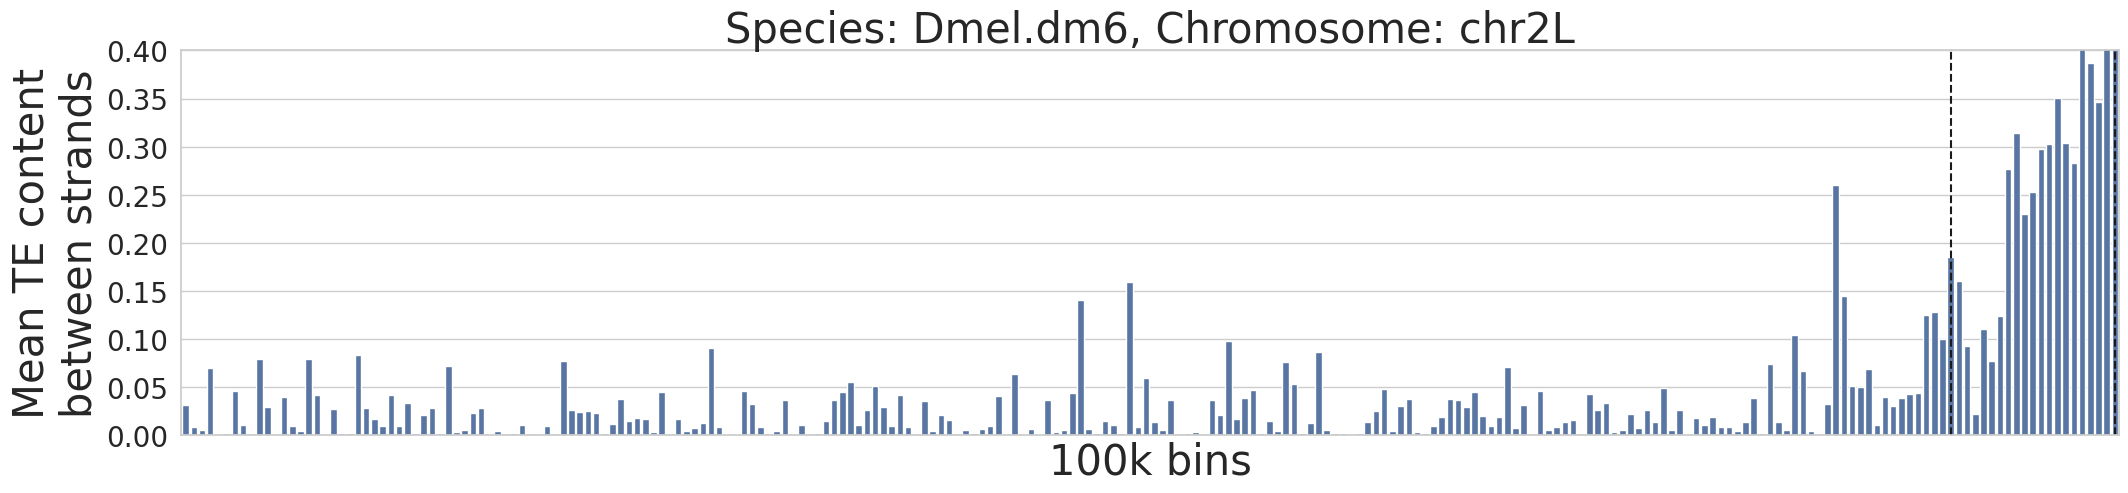

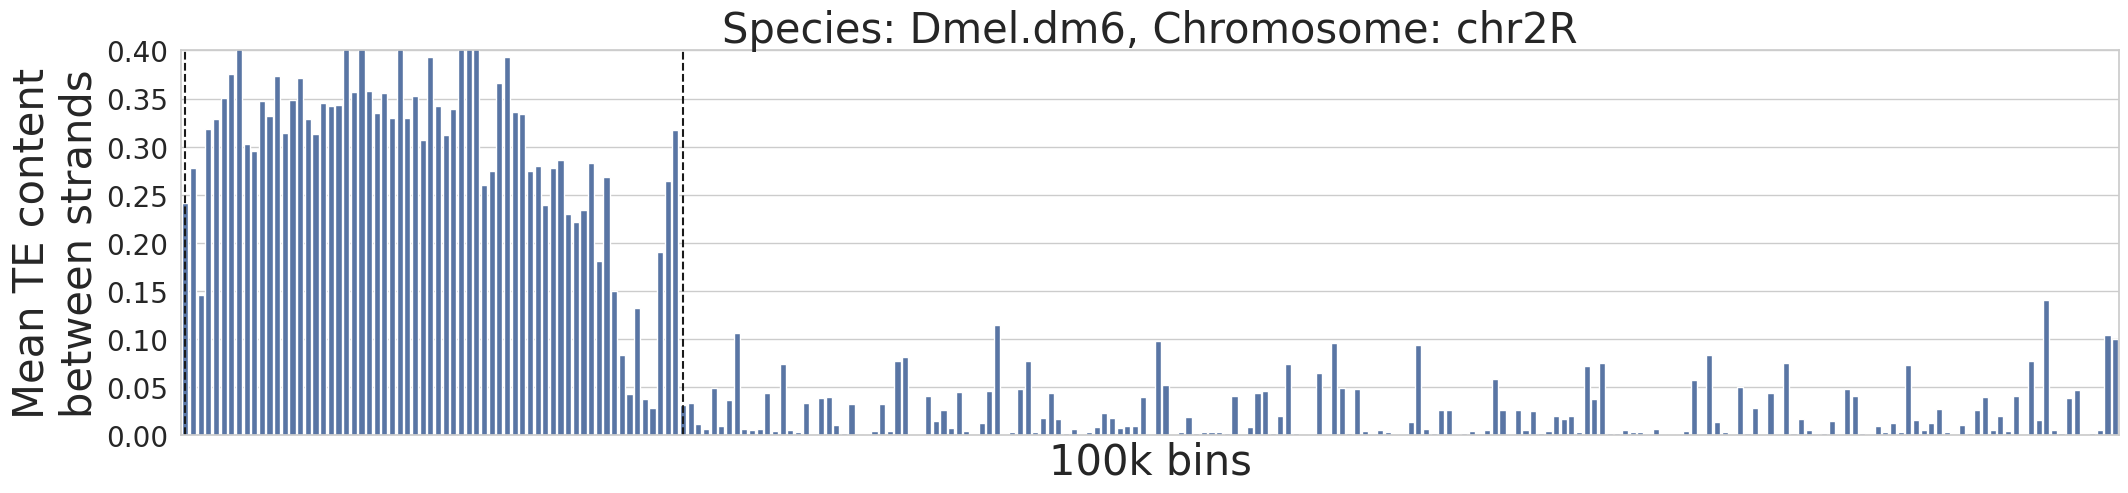

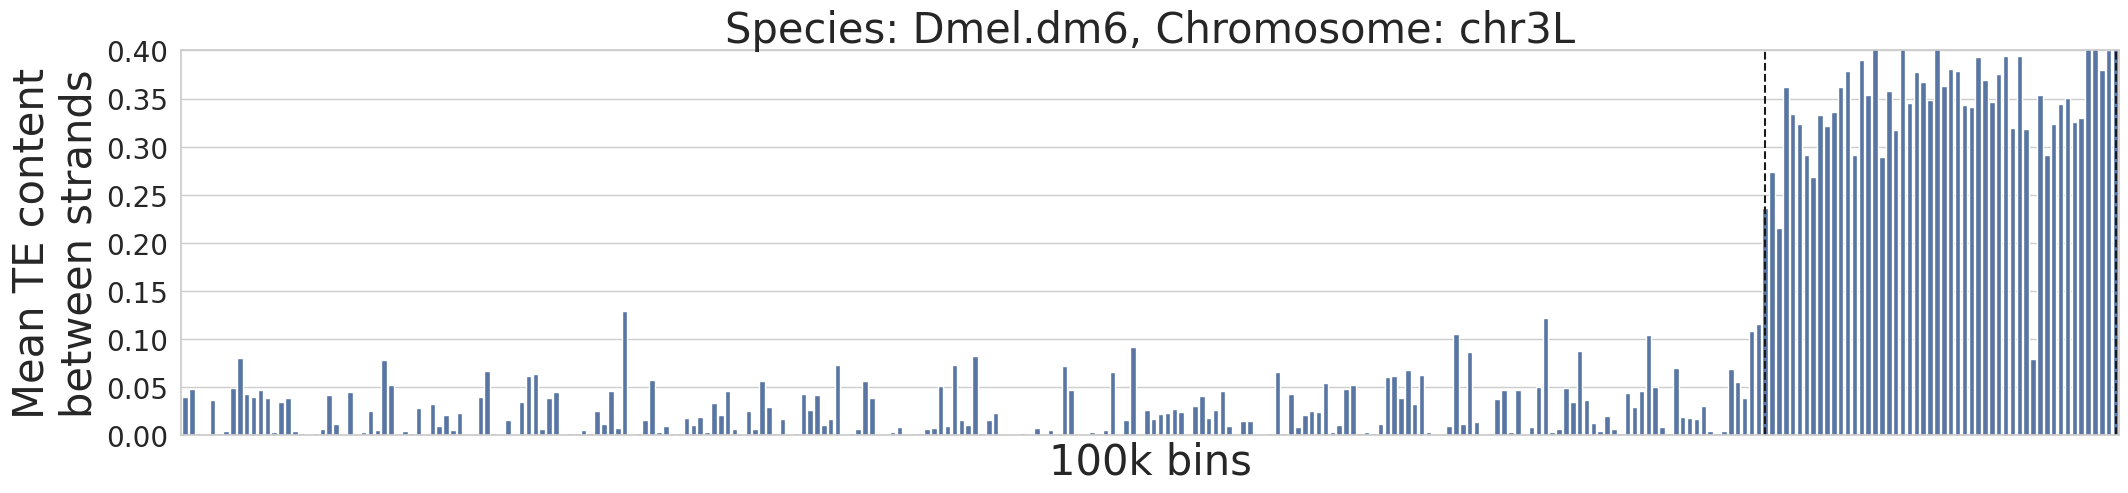

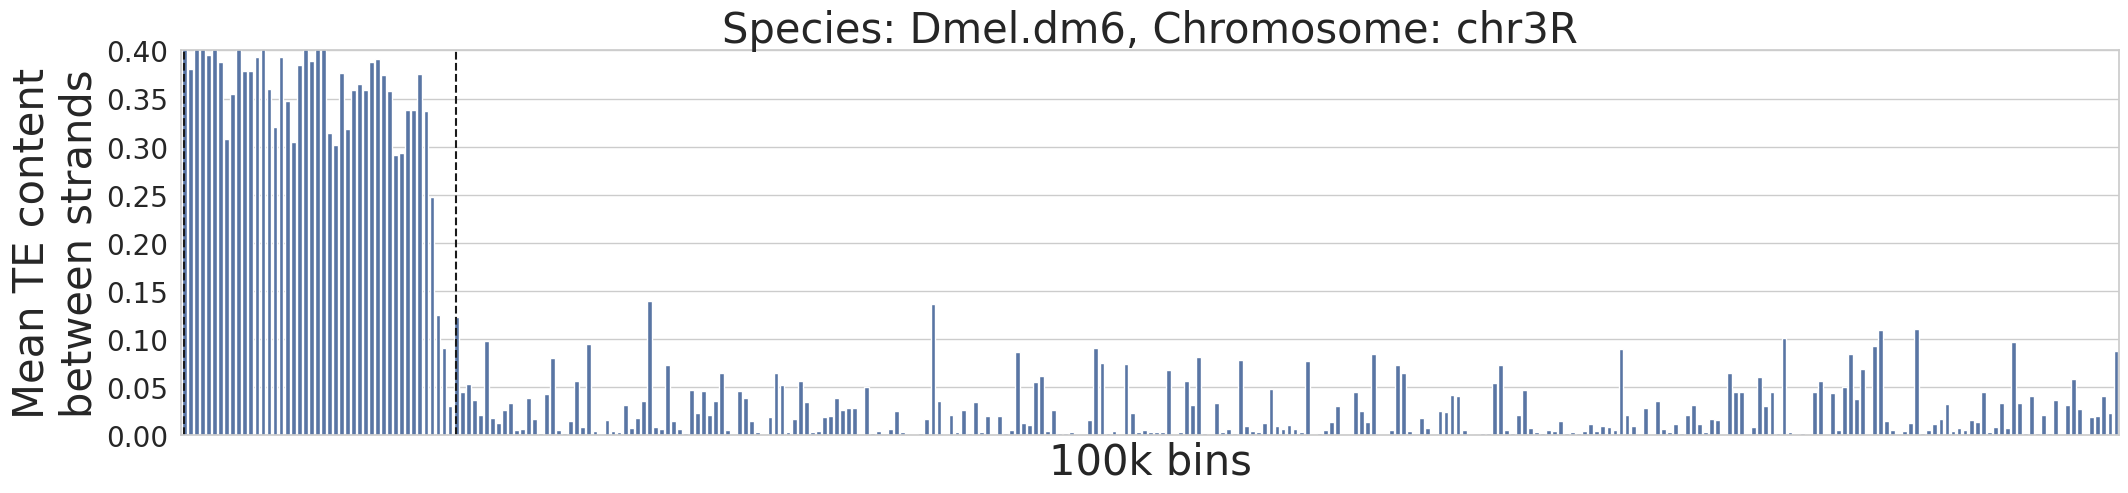

  0%|          | 0/1 [00:06<?, ?it/s]


In [7]:
for species in tqdm(['Dmel.dm6']):
    
    all_data=read_proces_05files(species,'bins/bins_100k/').reset_index(drop=True)
    all_data['coverage_sum']=all_data['coverage_plus']+all_data['coverage_minus']
    all_data['coverage_mean']=(all_data['coverage_plus']+all_data['coverage_minus'])/2
    
    for chromosome in ['chr2L','chr2R','chr3L','chr3R']:
        all_data_subset=all_data[all_data['chr']==chromosome]
        all_data_subset.insert(all_data_subset.shape[1],'100k bins (N)',[i+1 for i in range(0,all_data_subset.shape[0],1)])
        results_coordinates_subset=results_coordinates[(results_coordinates['species']==species)&(results_coordinates['chr']==chromosome)]
        
        sns.set(rc={'figure.figsize':(25,5)}, font_scale=1)
        sns.set_theme(style="whitegrid")
        g=sns.barplot(x='100k bins (N)', y='coverage_mean',data=all_data_subset)
        plt.xticks(fontsize=8, rotation=90)
        for row in results_coordinates_subset.iterrows():
            plt.axvline(x=int(row[1]['start']), color='k', linestyle='--')
            plt.axvline(x=int(row[1]['end']), color='k', linestyle='--')
        
        plt.title('Species: '+species+', Chromosome: '+ chromosome, fontsize=30)
        plt.ylim([0,0.4])
        plt.ylabel('Mean TE content'+'\n'+ 'between strands', fontsize=30)
        plt.xlabel('100k bins',fontsize=30)
        plt.yticks(fontsize=20)
        plt.xticks([])
        plt.show()
        
    break

## Export results

In [8]:
results_coordinates=results_coordinates.reset_index(drop=True)
results_coordinates.to_csv('data/centromere_coordinates.txt', sep='\t')